# Lab Assignment Two: Exploring Image Data
Machine Learning in Python<br/>
Diogo Benetti Faé Rodrigues<br/>
Alex Shockley<br/>
Jay Kynerd<br/>
02/21/2023

**[2 points] Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). What is the prediction task for your dataset and which third parties would be interested in the results? Why is this data important? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data.**

## Business Understanding

#### Business Understanding ...

**[.5 points] Read in your images as numpy arrays. Resize and recolor images as necessary.<br/>
[.4 points] Linearize the images to create a table of 1-D image features (each row should be one image).<br/>
[.1 points] Visualize several images.**

## Data Preparation

#### Before we start with some Data Reduction techniques, we must first read and prepare the data so it is ready to be used. The Stanford Dogs Dataset comes with 2 folders: Images and Annotation. Both have 120 folders inside of them, with the ID and name of each breed. The Images folder holds the actual dog images, and the Annotation folder contains information regarding where the dog is located in each image. This data is stored in XML.<br/>
#### The first step is to crop the images so that image is focused only on the the dogs, removing background noise.<br/>
#### The image at index 14558 is read with different value types and has 4 columns, instead of three. The fourth column is likely the alpha value. The data points seem to be already standardized, but since we don't know how it was standardized, it is best to drop that one image out of 20,580.

In [9]:
%%time
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import numpy as np

# About 50 s

# Receives breed and name of dog picture and
# returns cropped image focused on the dog
# Function adapted from https://www.kaggle.com/code/gabrielloye/dogs-inception-pytorch-implementation/notebook
def crop_dog(breed, dog):
    img = plt.imread(f'{os.getcwd()}/Images/{breed}/{dog}.jpg')
    tree = ET.parse(f'{os.getcwd()}/Annotation/{breed}/{dog}')
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    img = img[ymin:ymax, xmin:xmax, :]
    return img

dogs = []   # List of all the images stored as numpy arrays (matrices) in RGB
i = 0
for breed in os.listdir(f'{os.getcwd()}/Images'):
    curr_breed = breed
    # Uncomment to see progress
    # print(curr_breed, ' - ', i)
    for dog in os.listdir(f'{os.getcwd()}/Images/{breed}'):
        img = crop_dog(curr_breed, dog.split('.', 1)[0])
        dogs.append(img)

# Delete the weird image
del dogs[14558]

CPU times: user 34.9 s, sys: 4.18 s, total: 39 s
Wall time: 48.4 s


##### Below, we can see the difference between the original picture and the new picture that focuses on the dogs.

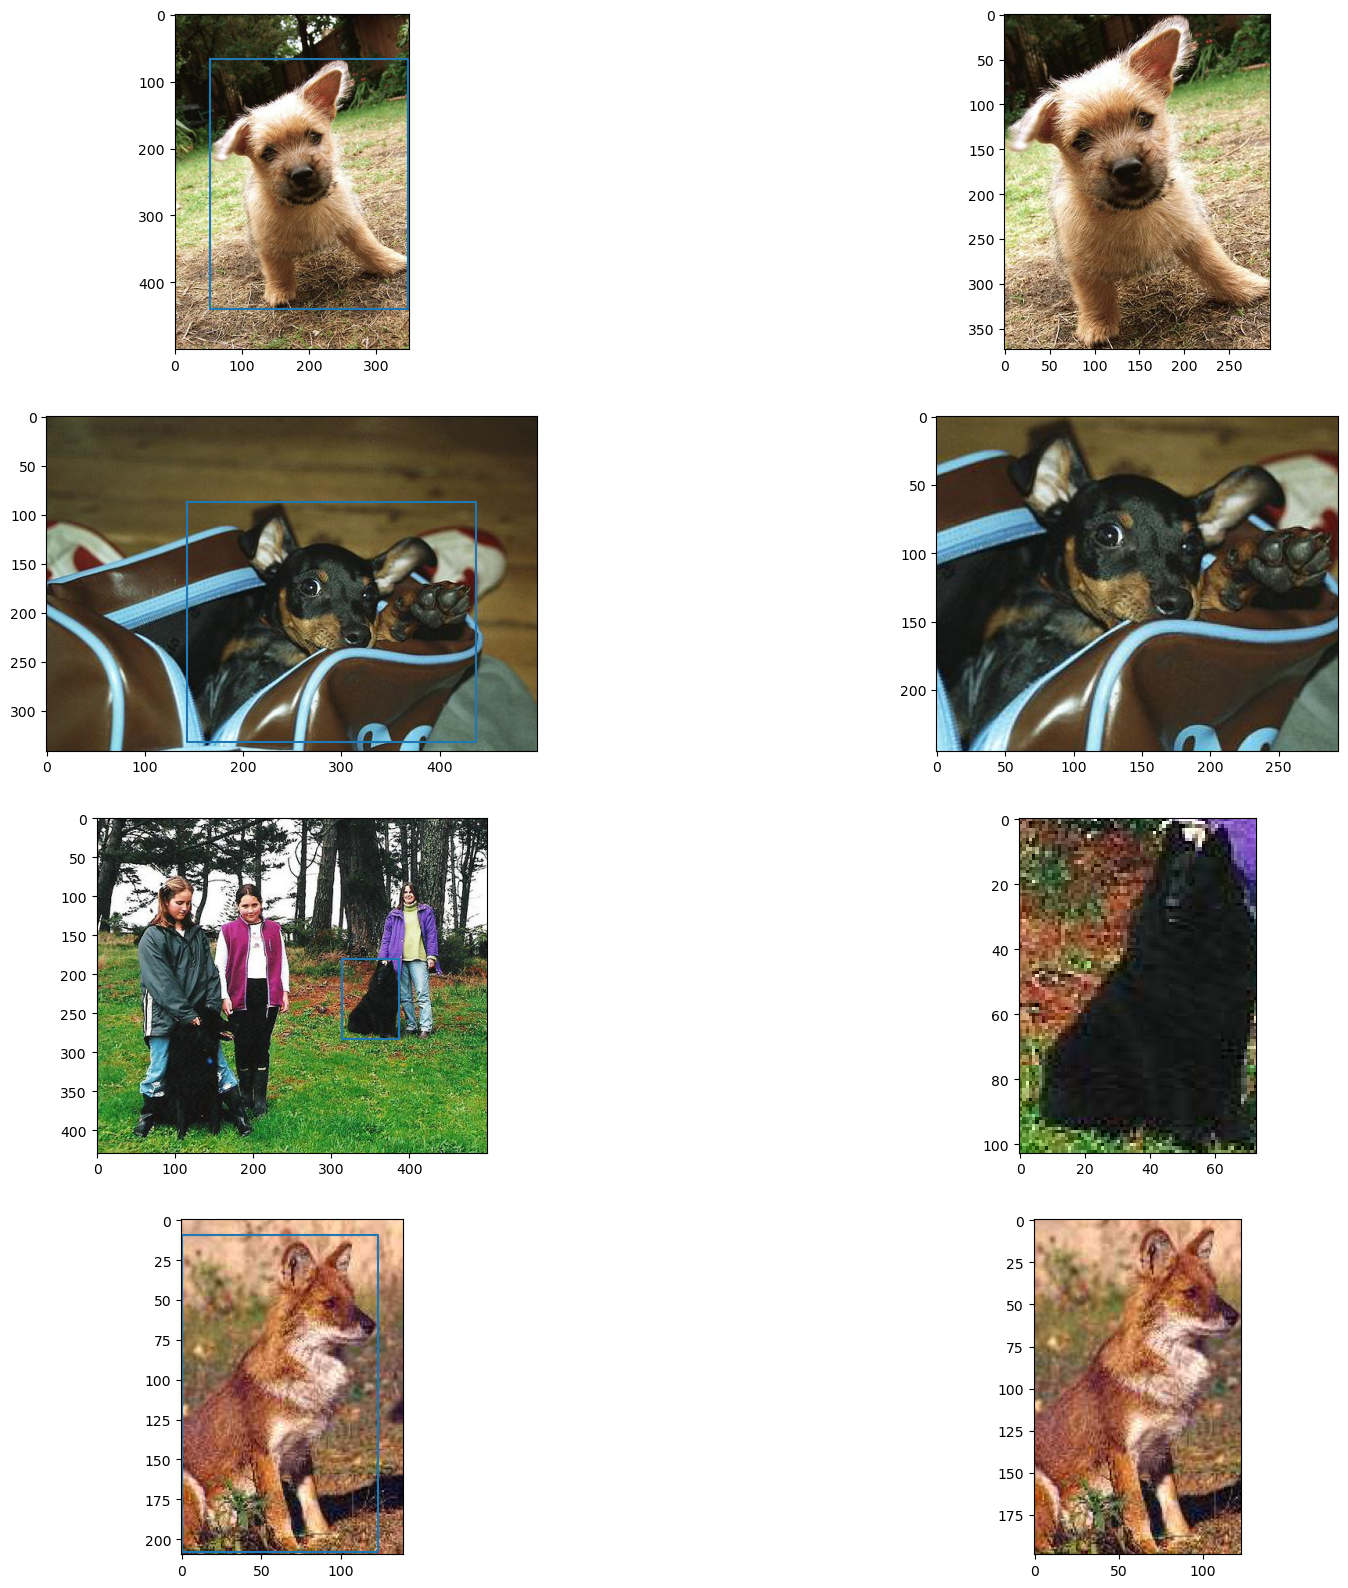

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Code adapted from https://www.kaggle.com/code/gabrielloye/dogs-inception-pytorch-implementation/notebook
Images_path = f'{os.getcwd()}/Images/'
Ann_path = f'{os.getcwd()}/Annotation/'
breed_list = os.listdir(Images_path)

plt.figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(421 + (i*2))
    breed = np.random.choice(breed_list)
    dog = np.random.choice(os.listdir(Ann_path + breed))
    img = plt.imread(Images_path + breed + '/' + dog + '.jpg')
    plt.imshow(img)  
    
    tree = ET.parse(Ann_path + breed + '/' + dog)
    # Figure out the vertices of the box
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    # Plot Original Image with box on top
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])
    # Crop the image to the dimensions of the box
    crop_img = crop_dog(breed, dog)
    # Plot the cropped image
    plt.subplot(422 + (i*2))
    plt.imshow(crop_img)

#### After removing the background noise, we must transform the images so that they all have the same dimensions. The images must have the same sizes so that they can linearized and standardized.

In [11]:
%%time

from PIL import Image
# About 45 s

# Resize Images into new list
i = 0
dogs_resized = []
for img in dogs:
    temp = Image.fromarray(dogs[i])
    temp_arr = np.array(temp.resize((150, 150)))
    dogs_resized.append(np.ravel(temp_arr))
    i += 1

CPU times: user 41.4 s, sys: 2.62 s, total: 44 s
Wall time: 45.1 s


##### With all numpy arrays of the same size, we can vectorize and then standardize the data so it is ready for Principal Component Analysis.<br/>
#### The same problem as before happens here. The element at index 14558 has different values, this time the problem is with its shape, which is (0,). So we will just pop that element out of the numpy array.

In [12]:
%%time

from sklearn.preprocessing import StandardScaler
# About 50 s with images of dimensions 150x150

X = np.array(dogs_resized, dtype='float')
scaled = StandardScaler().fit_transform(X)
scaled

CPU times: user 15 s, sys: 28.1 s, total: 43.1 s
Wall time: 51.9 s


array([[ 0.60201852,  0.65186909,  0.77098934, ...,  1.04960857,
         1.19555208,  1.54676509],
       [ 0.86340906,  0.95767161,  1.02667797, ..., -1.02329825,
        -0.32130546, -0.92250178],
       [ 0.95053925,  1.27803615,  1.73692415, ...,  1.30278803,
         1.50544771,  1.78268231],
       ...,
       [-0.90823798, -1.37225236, -1.21769999, ..., -0.08969899,
        -0.37023635, -0.74949582],
       [-1.44554078, -1.22663211, -0.93360151, ..., -1.49800973,
        -1.33254383, -1.15841899],
       [ 1.92349295,  1.88964119,  2.1204571 , ..., -1.38724372,
        -1.60981887, -0.63940112]])

In [ ]:
# -----------

In [ ]:
# a = Image.fromarray(dogs[14558])
# a.show()
# a = Image.fromarray(dogs[2005])
# a.show()
# # Width, Height
# b = a.resize((225, 225))
# b.show()

# np_dogs = np.array(dogs)
# w = 0
# h = 0
# j = 0
# for i in np_dogs:
#     w += w + np_dogs[i].shape[0]
#     h += h + np_dogs[i].shape[1]
#     print(j)
#     j += 1

# print('done')

# avg_w = w/20580
# avg_h = h/20580

# print('Average Width:', (avg_w))
# print('Average Height:', (avg_h))
# # np_dogs.shape
# type(dogs[14558])
# len(dogs)

In [ ]:
from PIL import Image
import numpy as np
import os
import cv2

small_w = np.Inf
small_h = np.Inf
small_dim = (np.Inf, np.Inf)


for breed in os.listdir(f'{os.getcwd()}/Images'):
    curr_breed = breed.split('-', 1)[1]
    # Uncomment to see progress
    # print(curr_breed, ' - ', loop_counter)
    for image in os.listdir(f'{os.getcwd()}/Images/{breed}'):
        img = Image.open(f'{os.getcwd()}/Images/{breed}/{image}')

        curr_dim = img.size
        curr_w = img.width
        curr_h = img.height

        if curr_dim < small_dim:
            small_dim = curr_dim
            # small_w = img.shape
            name = img.filename
        if curr_w < small_w:
            small_w = curr_w
        if curr_h < small_h:
            small_h = curr_h
    # break

print(small_dim)
print(small_w, small_h)
print(name)

(97, 134)
97 100
/Users/diogofae/Desktop/Classes/Machine Learning/Lab-Two-Exploring-Image-Data/Images/n02086646-Blenheim_spaniel/n02086646_1077.jpg


In [ ]:
%%time
import xml.etree.ElementTree as ET

def find_dog(breed, dog, data_dir):
    img = plt.imread(data_dir + 'images/Images/' + breed + '/' + dog + '.jpg')
    tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + dog)
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    img = img[ymin:ymax, xmin:xmax, :]
    return img

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 9.06 µs


In [151]:
def crop_image(img, heigth=100, width=97):
    return img[1:heigth, 1:width]

In [240]:
%%time

import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# plt.imshow(dog_array)
# Takes about 12:50 min to run

data = pd.DataFrame(columns=['Target'])
images = []
labels = []
dogs = []
breeds_folders = os.listdir(f'{os.getcwd()}/Images')
print(f"Number of Breeds: {len(breeds_folders)}")

loop_counter = 0
for breed in os.listdir(f'{os.getcwd()}/Images'):
    curr_breed = breed.split('-', 1)[1]
    # Uncomment to see progress
    # print(curr_breed, ' - ', loop_counter)
    for image in os.listdir(f'{os.getcwd()}/Images/{breed}'):
        dog = cv2.imread(f'{os.getcwd()}/Images/{breed}/{image}')
        # Correct color bc cv2 uses BGR color format and matplotlib uses RGB color format
        dog = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)
        # print(dog.shape)
        # dog = dog[1:98, 1:101]
        dog = crop_image(dog, 97, 97)
        # print(dog.shape)
        if dog.shape != (96, 96, 3):
            print(dog.shape)
            print('ERROR', curr_breed, image)
        
        dogs.append(dog)
        dog_series = np.ravel(dog)

        images.append(np.array(dog_series))
        labels.append(curr_breed)
    #     if loop_counter == 1:
    #         break
    #     loop_counter += 1
    # loop_counter += 1

        # dog_array = np.array(dog)
        # dog_series = np.ravel(dog).tolist()
        # data = pd.concat([data, dog_series], axis=1)
        # data.insert(value=dog_series, column=)
        # data.join(dog_series, ignore_index=True)
        # data.loc[len(data)] = dog_series
        # data = data.append(dog_series, ignore_index=True)
        # data["Target"] = curr_breed
        # break
    # break

# print('DONE')

dogs = np.array(dogs)
X = np.array(images, dtype='float')
y = np.array(labels)

Number of Breeds: 120
CPU times: user 23.2 s, sys: 7.41 s, total: 30.7 s
Wall time: 38.8 s


In [ ]:
dogs
# dogs = np.array(dogs)
X = np.array(images)
# y = np.array(labels)
# l = np.array(images)
# l

In [ ]:
print(X[0].shape)
print(X[1].shape)
X.shape
# Change dimensions
# Put all 0s, so it is all black
# Better options is to crop it

(27936,)
(27936,)


(20580, 27936)

#### Now that we have the images, we can visualize some of them and check the data.

NameError: name 'y' is not defined

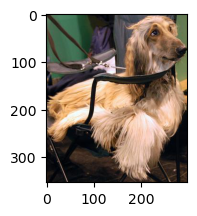

In [33]:
plt.figure(figsize=(1.7 * 3, 2.3 * 3))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(3 * 3):
    plt.subplot(3, 3, i + 1)
    # 20580
    rand_idx = np.random.randint(0, 20580)
    plt.imshow(dogs[rand_idx], cmap=plt.cm.gray)
    plt.title(y[rand_idx], size=12)
    plt.xticks(())
    plt.yticks(())

#### Before starting the data reduciton, we must first prepare the images so they are ready to be analyzed. **First step is to convert the images into grayscale because just the shapes and sizes of the dogs should be enough for the algorithms to work. We will not be converting the images into grayscale because the colors of the dogs are an important factor when identifying their breeds.** Then, we will standardize the values to prevent larger values to have greater influence.

In [ ]:
from sklearn.preprocessing import StandardScaler

# print(X)
# XX = X.tolist()
# df = pd.DataFrame(X)
# df
scaled = StandardScaler().fit_transform(X)
# dog
# df.head()
scaled

array([[ 1.38010616,  1.44286113,  1.67132031, ..., -0.34098861,
        -0.71219565, -0.75097049],
       [ 1.16212473,  1.90595988,  1.99966523, ...,  1.92670285,
         2.05161984,  2.20187732],
       [ 0.30382287,  0.5575253 ,  0.8832925 , ..., -0.41367103,
        -0.78609446, -0.85279283],
       ...,
       [-0.78608426, -1.34935188, -1.1261784 , ..., -0.29737916,
        -1.1999278 , -1.20189799],
       [-1.03131337, -1.15866416, -0.94230524, ..., -0.34098861,
         0.42584602,  1.75094983],
       [ 1.76157365,  1.71527216,  1.82892587, ...,  1.08358679,
         0.2780484 , -0.34368114]])

**[.5 points] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.<br/>
[.5 points] Perform linear dimensionality reduction of your image data using randomized principle components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.<br/>
[2 points]  Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?<br/>
[1 points] Perform feature extraction upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, DAISY, etc.).<br/>
[2 points] Does this feature extraction method show promise for your prediction task? Why? Use visualizations to analyze this questions. For example, visualize the differences between statistics of extracted features in each target class. Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.**

## Data Reduction

For the data reduction portion of this notebook, we will be using Principal Components Analysis (PCA) to reduce the number of attributes we will use and getting rid of the curse of dimensionality. 

**[1 point] Perform feature extraction upon the images using DAISY. Rather than using matching on the images with the total DAISY vector, you will instead use key point matching. You will need to investigate appropriate methods for key point matching using DAISY. NOTE: this often requires some type of brute force matching per pair of images, which can be computationally expensive.**

## Exceptional Work